# AI4Spec 2: Predicting multiple energy levels with neural networks

In these tutorials exercises, we review different AI approaches to predicting ground or excited state energy levels simply based on the atomic structure of materials. Here we focus on molecules and molecular orbitals, but the sample principles apply to crystal structures and electronic bands.

We start by predicting individual states (Tutorial 1), proceed towards predicting multiple states at once (Tutorial 2) and finish by predicting entire spectral curves (Tutorial 3). The tutorials were prepared by Milica Todorović (University of Turku) and Kunal Ghosh (Aalto University).

<img src="https://raw.githubusercontent.com/milicasan/TutorialImages/89238bfff57a38ec78ecbd08765b63bd15ff9e2c/AI4spec.png" width="600px"/>

In the exercise below, our AI objective is to train a model to predict a multiple electronic energy levels, such as an energy band. This is a more complex example of supervised machine learning regression, where the objective (label) is a list of single floating-point numbers. Few AI models can address this task, because most supervised learning focuses on learning only one numerical value, and here we have several. Neural network (NN) models are well-suited for this type of task. Given the flexible NN architectures, vectors can be used as both input and output.

We use a large dataset of molecular structures and their computed HOMO energies to train the AI. The HOMO energies of all molecules were pre-computed with first principles quantum mechanical methods (DFT) to obtain the target data that our model can be trained on. Our label and learning objective is now a vector of energies for 16 occupied molecular orbitals, terminating in the HOMO. We start by learning the HOMO first, and then proceed to learn multiple levels at the same time.


## Using neural networks to predict multiple electronic levels

NN models are notoriously data-demanding, so the QM7 dataset we used before may be too small. We switch to the QM9 dataset of 132k molecules for NN work. For the purposes of this tutorial, we take a subset of 7000 molecules, but in your own time you can try the entire dataset.  

Detailed descriptions and results for both QM7 and QM9 datasets can be found in [K. Ghosh, et al. "Deep Learning Spectroscopy: Neural Networks for Molecular Excitation Spectra." Adv. Sci. 6 1801367 (2019)](https://onlinelibrary.wiley.com/doi/full/10.1002/advs.201801367). Full datasets employed is this study are available from [Zenodo record 3386508](https://zenodo.org/records/3386508).

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import math, random
from scipy.sparse import load_npz
from matplotlib.colors import LinearSegmentedColormap
import time

### Load and visualize data

First, we load the data. The molecules are represented by their Coulomb matrices, which were computed with the [Dscribe](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub) package. The output data y is a matrix that contains the corresponding 16 HOMO energies for all molecules.

In [2]:
!wget https://zenodo.org/records/10069732/files/coulomb_7000.npz
!wget https://zenodo.org/records/10069732/files/energies_7000.npz

--2024-03-04 21:34:38--  https://zenodo.org/records/10069732/files/coulomb_7000.npz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47096264 (45M) [application/octet-stream]
Saving to: ‘coulomb_7000.npz.1’

coulomb_7000.npz.1  100%[===================>]  44.91M  46.3MB/s    in 1.0s    

2024-03-04 21:34:39 (46.3 MB/s) - ‘coulomb_7000.npz.1’ saved [47096264/47096264]

--2024-03-04 21:34:40--  https://zenodo.org/records/10069732/files/energies_7000.npz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 896264 (875K) [application/octet-stream]
Saving to: ‘energies_7000.npz.1’

energies_7000.npz.1 100%[===================>] 875.26K  4.13MB/s    in 0.2s    

20

In [3]:
# Here we load all the data
x = np.abs(np.load("coulomb_7000.npz")['arr_0'])
energies = np.load("energies_7000.npz")['arr_0']

# energy labels are saved from lowest to highest value.
# HOMO is the highest energy molecular orbital, so we pick the last column as the HOMO label.
y = energies[:,-1]

# we can also try to learn HOMO, HOMO-1 and HOMO-2 at the same time.
y_multi = energies[:,-3:]

print("Number of molecules:", len(y))

Number of molecules: 7000


Let us review the Coulomb matrix for a random molecule in the dataset.

In [4]:
rand_mol = random.randint(0, len(y))

# Consider the size of the CM - what is the size of our descriptor?
print(x[rand_mol].shape)

# Let's take a look at the matrix elements
print(x[rand_mol])

(29, 29)
[[36.858 23.545 19.643 14.298 12.615  8.577 10.93  14.165  5.46   5.451
   5.466  2.245  2.124  2.203  1.135  2.263  2.071  0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [23.545 36.858 33.353 23.482 19.429 13.106 16.645 23.444  2.74   2.752
   2.774  3.039  2.741  2.759  1.571  2.759  2.788  0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [19.643 33.353 73.517 19.681 21.95  15.243 18.479 20.284  2.35   2.933
   2.975  8.241  2.959  2.359  1.972  2.415  3.243  0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [14.298 23.482 19.681 36.858 33.39  15.238 15.014 14.537  2.16   2.15
   1.729  2.339  5.456  5.44   1.819  2.07   1.759  0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [12.615 19.429 21.95  33.39  73.517 35.114 23.509 16.879  1.95   1.931
   1.732  2.55   3.934  3.857  3.966  2.322  2.135  0.     0.     0.
   0.     0.     0.    

Note that QM9 molecules are slightly larger than the QM7 ones, so the descriptor is larger, and can contain more zero padding. Below, we visualize the Coulomb matrix of the random molecule.

<Figure size 640x480 with 0 Axes>

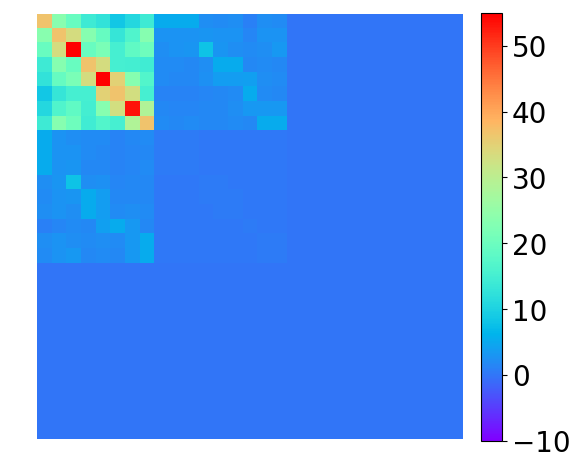

In [5]:
shape = (29, 29)
mat = x[rand_mol].reshape(shape)

plt.figure()
plt.figure(figsize = (6,6))
plt.imshow(mat, origin="upper", cmap='rainbow', vmin=-10, vmax=55, interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)
plt.axis('off')
plt.show()

Now, we review the energy entry for the same random molecule index. What follows is a list of 16 highest occupied molecular orbitals, ending in HOMO. In other words, you now have access to HOMO-15, HOMO-14, HOMO-13... HOMO-2, HOMO-1, HOMO energies.


In [6]:
# Here we review the entire vector of orbital energies
print(energies[rand_mol,:])

# Here we check the HOMO only
print(y[rand_mol])

# Here we check the top 3 occupied states
print(y_multi[rand_mol])

[-13.97184 -12.99997 -12.46609 -11.83582 -11.2511  -10.46114 -10.41363
 -10.08263  -9.84337  -9.36033  -8.81967  -8.51355  -8.09764  -6.67936
  -6.13557  -5.84277]
-5.84277
[-6.67936 -6.13557 -5.84277]


Now, let us analyse the HOMO values. We plot a histogram to review the distribution of the labels, and compute the mean value. You can compare these QM9 HOMOs to the QM7 HOMOs in the previous dataset: is there much difference?

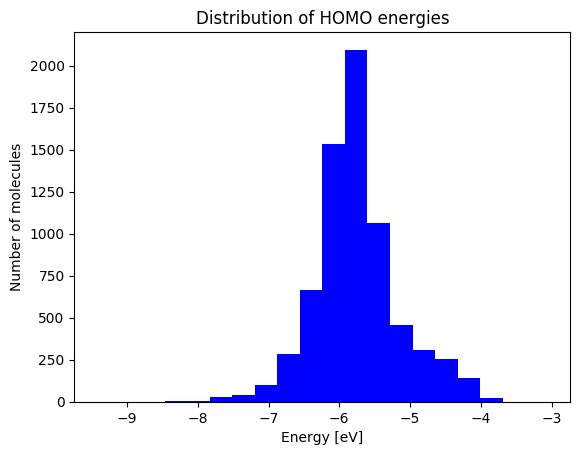

Mean value of HOMO energies in QM9 dataset: -5.75 eV
[-9.42518 -8.12121 -6.48731 ... -5.94942 -5.47667 -5.69919]


In [7]:
plt.hist(y, bins=20, density=False, facecolor='blue')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.title("Distribution of HOMO energies")
plt.show()

## mean value of distribution
print("Mean value of HOMO energies in QM9 dataset: %0.2f eV" %np.mean(y))
print(y)

As before, we shuffle the data before dividing the dataset into training and test set, just in case there was some ordering in the input files.

In [8]:
## shuffle the data

c = list(zip(x, y))
random.shuffle(c)

x, y = zip(*c)

x = np.array(x)
y = np.array(y)

Now, we divide the data into training and test set. Note that for neural networks **we need also a validation set**. Validation set serves to check the quality of the NN learning during training and hyperparameter optimisation. After the NN is optimised, the final prediction accuracy will be evaluated on the test set.

In [9]:
# decide how many samples to take from the database for training, testing and validation
n_train = 1000
n_test = 500
n_val = 500

# split data in training and test
# take first n_train molecules for training
X_train  = x[0:n_train]
Y_train = y[0:n_train]

# take the next n_test data for testing
X_test = x[n_train:n_train + n_test]
Y_test = y[n_train:n_train + n_test]

# take the next n_val data for validation
X_val = x[n_train + n_test: n_train + n_test+ n_val]
Y_val = y[n_train + n_test: n_train + n_test+ n_val]

Check that the training data resemble the test data well by plotting the distribution of HOMO energies for both sets. The distributions should be centered around the same mean value and have the same shape.

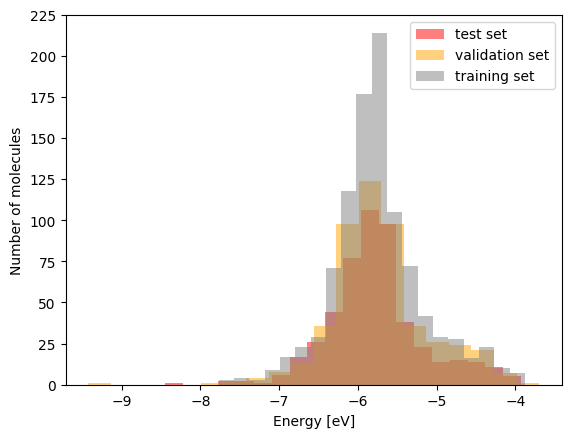

Mean value of HOMO energies in training set: -5.74 eV
Mean value of HOMO energies in validation set: -5.72 eV
Mean value of HOMO energies in test set: -5.77 eV


In [10]:
plt.hist(Y_test, bins=20, density=False, alpha=0.5, facecolor='red', label='test set')
plt.hist(Y_val, bins=20, density=False, alpha=0.5, facecolor='orange', label='validation set')
plt.hist(Y_train, bins=20, density=False, alpha=0.5, facecolor='gray', label='training set')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

## mean value of distributions
print("Mean value of HOMO energies in training set: %0.2f eV" %np.mean(Y_train))
print("Mean value of HOMO energies in validation set: %0.2f eV" %np.mean(Y_val))
print("Mean value of HOMO energies in test set: %0.2f eV" %np.mean(Y_test))

### Implementing the CNN

Now we have a choice of NN architectures. The Multi Layer Perceptron (MLP) is the simplest deep NN architecture, but here we will review and deploy the Convolutional Neural Network (CNN). CNN is well-suited to image-like data such as the CM descriptor, and [previous work](https://onlinelibrary.wiley.com/doi/full/10.1002/advs.201801367) has established that CNNs predictive accuracy is better than that of MLPs in predicting electronic energy levels.

<img src="https://raw.githubusercontent.com/milicasan/TutorialImages/46df4d358952ce9a1ec2037a3f622388249777dd/MLP-CNN.png" width="600px"/>

Below we demonstrate how to use torch to build a simple CNN and apply it.


PyTorch requires the user to set up the classes for the dataset and the AI model. Let's start with the dataset class:

In [12]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import torch
import lightning.pytorch as pl
import torch.nn.functional as F
import numpy as np

# Define the Dataset class
class SimpleDataset(Dataset):

    # Here we specify that the CM is a matrix with 29x29 entries.
    # It is then necessary to flatten this into a long vector, which is input to the CNN
    def __init__(self, features, labels):
        self.x = torch.from_numpy(features).reshape(-1, 29, 29).unsqueeze(1).float()
        self.y = torch.from_numpy(labels).float()
        print(self.x.shape)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {"X" : self.x[idx], "y" : self.y[idx]}

Now we set up a simple CNN model by defining all the functional components this AI model will need, such as:

*  network architecture (number of hidden layers and neurons)
*  activation function type between hidden layers
*  functions to load training and validation data
*  training steps on training and validation data
*  optimisers for NN training

The model is trained by adjusting hyperparameters (weights and biases) so as to minimise the errors between current predictions and reference values. This quantity is called the **loss function**, and here we use the [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) to quantify it.

In [14]:
# Parameters for NN architecture:
# Conv2D
output_length = 1  # this is size of output - HOMO is one number
nConv = 20         # number of convolutional matrices
filter = 3         # size of filter matrix (3x3)
pad = 1            # padding for the filter scan

# MaxPool2D
maxp = 4           # size of maxpool layer

# Hyperparameters for NN training:
batch = 64            # total training set is divided into batches for training
learning_rate = 1e-3  # the rate of updating the network weights during training


# Define the network
class CNN(pl.LightningModule):

    # this is the main NN architecture
    def __init__(self, output_length):
        super(CNN, self).__init__()

        # Below we define 2 hidden layers (design choice)
        # followed by a MaxPool layer and a linear layer
        # convolution key parameters: no. of input and output nodes

        # 1st convolution, 1 = input matrix
        self.conv1_1 = nn.Conv2d(1, nConv, filter, padding=pad)
        # 2nd convolution
        self.conv1_2 = nn.Conv2d(nConv, nConv, filter, padding=pad)
        # 3rd convolution
        self.conv1_3 = nn.Conv2d(nConv, maxp, filter, padding=pad)
        # MaxPool - different hyperparameters apply
        self.pool = nn.MaxPool2d(maxp,maxp)
        # The linear layer size is approximately 4x7x7
        self.fc1 = nn.Linear(maxp*7*7, output_length)

    # this describes how the NN is propagated forward
    def forward(self, x, labels=None):

        # relu is used after the 1st layer
        x = F.relu(self.conv1_1(x))
        # relu is used after the 2nd layer
        x = F.relu(self.conv1_2(x))
        # relu is used after the 3rd layer
        x = F.relu(self.conv1_3(x))
        # print(x.shape)
        x = self.pool(x)
        x = x.view(-1, 4*7*7)
        outputs = self.fc1(x)

        # Here we set the MSE as the metric for the loss function
        loss = 0
        if labels is not None:
            loss = nn.functional.mse_loss(outputs.squeeze(), labels.squeeze())
        return loss, outputs

    # note batch size below
    def train_dataloader(self):
        dataset = SimpleDataset(X_train, Y_train)
        return DataLoader(dataset, batch_size=batch)

    # note batch size below
    def val_dataloader(self):
        dataset = SimpleDataset(X_val, Y_val)
        return DataLoader(dataset, batch_size=batch, num_workers=1)

    def training_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # print(f"Training loss : {loss}")
        return loss

    def validation_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # print(f"Validation loss : {loss}")
        return loss

    # We chose the adam algorithm for backpropagation training.
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=learning_rate)
        return optimizer


This is how our network looks like:

<img src="https://raw.githubusercontent.com/milicasan/TutorialImages/51cdde9d1a6daaed0e752440855fba51cf68afd9/CNNarch.png" width="800px"/>


In this instance, we have the following layers.


* Input layer: Coloumb matrix (29x29)
* Hidden layer 1: 20 matrices of 29x29 (convolution before/after)
* Hidden layer 2: 20 matrices of 29x29 (convolution before/after)
* MaxPool layer: 4 matrices of 29x29 (convolution before/ pooling after)
* Linear layer: 4x7x7
* Output layer: 1

The hidden layers are connected by convolution operations: there are 2 hidden layers and 3 convolutional operations. Find out more about how CNNs operate in [this useful guide](https://poloclub.github.io/cnn-explainer/).

## Training the CNN

Now, let's create our CNN model using the class we defined above. We set *output_length to 1* to learn the HOMO only. Next, we define the NN training function, which is then applied to the CNN. The key parameter is the *number of epochs*, which we considerably reduce here in the interest of time.

Ideally our model should generalise well and thus make good predictions on data that it was not training on. For this reason we monitor the loss on both the training set and validation set (data not used in training).
We want to stop the training as soon as the validation loss does not decrease anymore and starts to depart from the training loss.

This can be automated with the **EarlyStopping** callback. In the following we will continue training the above model until the validation loss does not decrease anymore and do not start from scratch. If no lower value of the validation loss is found in 3 consecutive steps (patience=3), the training will stop.

In [17]:
# This is the CNN AI model. It's created blank.
cnn = CNN(output_length = output_length)

# Here, we define the NN training function, which is then applied to the CNN.
# The fit function returns a trained CNN.
trainer = pl.Trainer(max_epochs=2, callbacks=[EarlyStopping(monitor="train_loss", mode="min", patience=3)])
trainer.fit(cnn)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params
--------------------------------------
0 | conv1_1 | Conv2d    | 200   
1 | conv1_2 | Conv2d    | 3.6 K 
2 | conv1_3 | Conv2d    | 724   
3 | pool    | MaxPool2d | 0     
4 | fc1     | Linear    | 197   
--------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]torch.Size([500, 1, 29, 29])
torch.Size([1000, 1, 29, 29])                                              
Epoch 0:  67%|██████▋   | 16/24 [00:00<00:00, 31.42it/s, loss=9.1, v_num=2] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  67%|██████▋   | 16/24 [00:00<00:00, 31.95it/s, loss=1.64, v_num=2, val_loss=0.998, train_loss=9.300]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 25.57it/s, loss=1.64, v_num=2, val_loss=1.490, train_loss=1.310]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 25.33it/s, loss=1.64, v_num=2, val_loss=1.490, train_loss=1.310]


CNN training is now complete and it's time to review prediction accuracy. We use the trained CNN model and input training and test data to compare these two results. You can follow the same syntax to check the MSE on the validation set.

In [18]:
# Here we compute the MSE accuracy on the training set
X_train = X_train.reshape(-1, 1, 29, 29)

# Below we insert training set X and Y to obtained the MSE (loss).
loss, _ = cnn(torch.Tensor(X_train), torch.Tensor(Y_train))
print(f"Training loss: {loss}")

Training loss: 1.1090996265411377


In [19]:
# Here we compute the MSE accuracy on the test set
X_test = torch.Tensor(X_test).reshape(-1, 29, 29).unsqueeze(1).float()
Y_test = torch.Tensor(Y_test).float()

# Below we insert test set X and Y to obtained the MSE (loss).
loss, Y_pred = cnn(X_test, Y_test)
print(f"Test loss {loss}")

Test loss 1.2540472745895386


How does the test set MSE compare to the training set MSE? Is this what you expect to find?

Now, let's review the quality of HOMO predictions in a scatter plot. What do you observe?

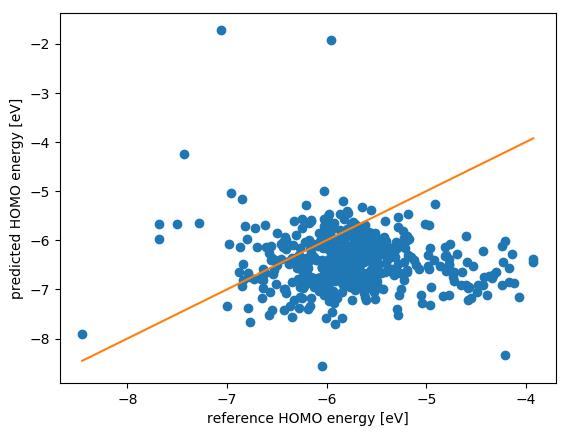

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = Y_pred.detach().numpy().flatten()
y_test = Y_test.detach().numpy().flatten()

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel("reference HOMO energy [eV]")
plt.ylabel("predicted HOMO energy [eV]")
plt.show()

### Predicting multiple HOMO energies

Now that we have successfully trained a CNN to predict single energy levels, let's repeat the process for several energy levels. Here, X vector is the same, but we will define a new Ym (multi) label that predicts 3 levels at the same time (HOMO, HOMO-1, and HOMO-2).

In [ ]:
# Generate test/training/validation sets for y_multi
Ym_train = y_multi[0:n_train]
Ym_test = y_multi[n_train:n_train + n_test]
Ym_val = y_multi[n_train + n_test: n_train + n_test+ n_val]

Next, we define a new network called *CNN_multi*. We keep almost all the model exactly the same, but we insert Ym training and test data where Y used to be. The comments below indicate the changes.

In [ ]:
class CNN_multi(pl.LightningModule):

    # note the change in name
    def __init__(self, output_length):
        super(CNN_multi, self).__init__()

        self.conv1_1 = nn.Conv2d(1, nConv, filter, padding=pad)
        self.conv1_2 = nn.Conv2d(nConv, nConv, filter, padding=pad)
        self.conv1_3 = nn.Conv2d(nConv, maxp, filter, padding=pad)
        self.pool = nn.MaxPool2d(maxp,maxp)
        self.fc1 = nn.Linear(maxp*7*7, output_length)

    def forward(self, x, labels=None):

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        print(x.shape)
        x = self.pool(x )
        x = x.view(-1, 4*7*7)
        outputs = self.fc1(x)

        loss = 0
        if labels is not None:
            loss = nn.functional.mse_loss(outputs.squeeze(), labels.squeeze())
        return loss, outputs

    # Here we insert Ym training data
    def train_dataloader(self):
        dataset = SimpleDataset(X_train, Ym_train)
        return DataLoader(dataset, batch_size=batch)

    # Here we insert Ym validation data
    def val_dataloader(self):
        dataset = SimpleDataset(X_val, Ym_val)
        return DataLoader(dataset, batch_size=batch, num_workers=1)

    def training_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # print(f"Training loss : {loss}")
        return loss

    def validation_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # print(f"Validation loss : {loss}")
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=learning_rate)
        return optimizer

That was easy! Now it's time to use our new CNN_multi. We proceed in the same way as before, but now remember that the length of the output vector is 3, for 3 energy levels.

In [ ]:
output_length = 3
cnn_multi = CNN_multi(output_length = output_length)

# Next, we define the NN training function, which is then applied to the CNN.
trainer = pl.Trainer(max_epochs=10, callbacks=[EarlyStopping(monitor="train_loss", mode="min", patience=3)])
trainer.fit(cnn_multi)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type      | Params
--------------------------------------
0 | conv1_1 | Conv2d    | 200   
1 | conv1_2 | Conv2d    | 3.6 K 
2 | conv1_3 | Conv2d    | 724   
3 | pool    | MaxPool2d | 0     
4 | fc1     | Linear    | 591   
--------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type      | Params
----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

torch.Size([500, 1, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([1000, 1, 29, 29])


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([40, 4, 29, 29])


Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([64, 4, 29, 29])
torch.Size([52, 4, 29, 29])


 Let us check the final prediction accuracy, this time directly on the test data. We use the trained CNN model and input the Ym test data. The result below is the joint MSE over the 3 values we are predicting.

In [ ]:
# Here we compute the MSE accuracy on the test set
X_test = torch.Tensor(X_test).reshape(-1, 29, 29).unsqueeze(1).float()
Ym_test = torch.Tensor(Ym_test).float()

# Below we insert test set X and Ym to obtained the MSE (loss).
loss, Ym_pred = cnn_multi(X_test, Ym_test)
print(f"Test loss {loss}")

torch.Size([500, 4, 29, 29])
Test loss 0.8187092542648315


Compare the MSE when we predict 3 electronic levels to the previous one, where we predicted only 1 level. Are the results similar or very different?

Next, let us review the quality of predictions in a scatter plot. Because we predicted 3 levels simultaneously, we need to build 3 different scatter plots. How does this look?

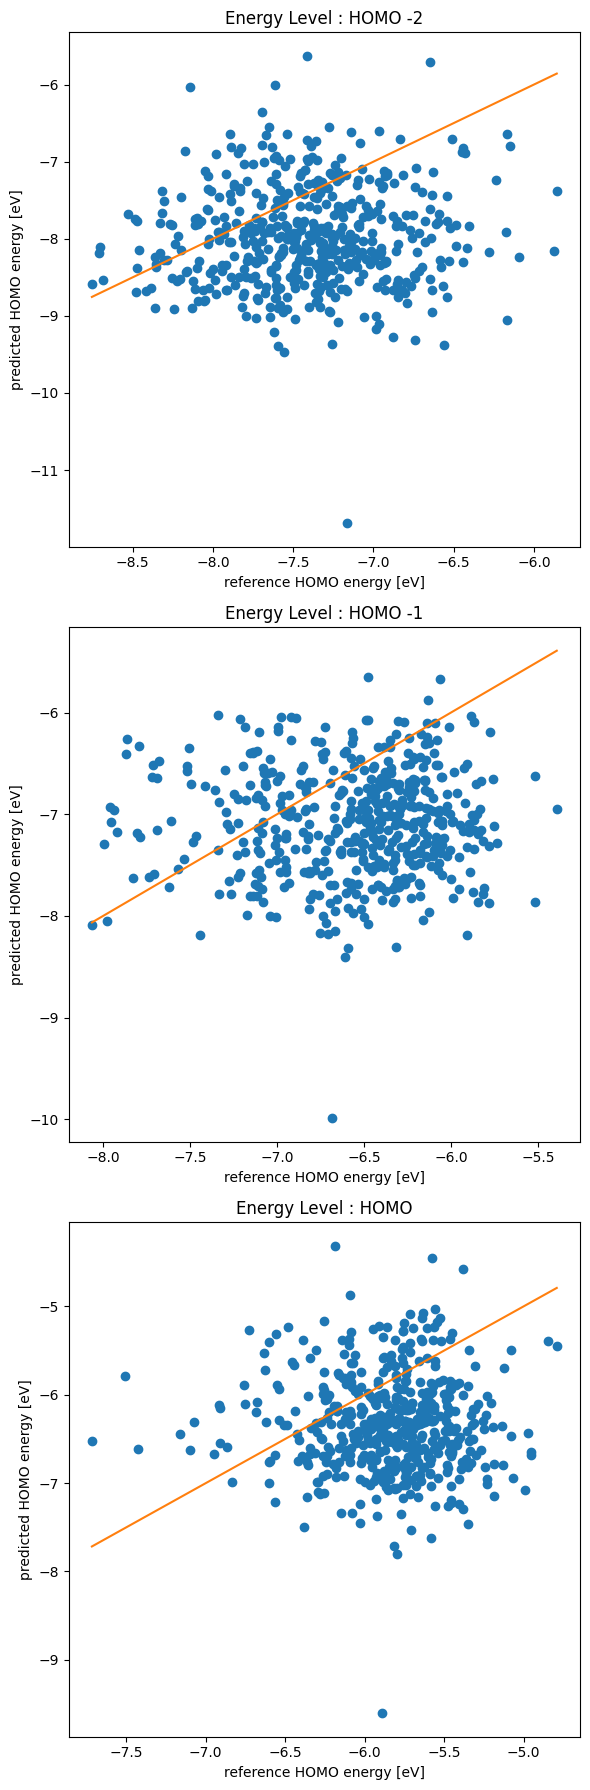

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Below we define the predicted values and the reference test values.
ym_pred = Ym_pred.detach().numpy()
ym_test = Ym_test.detach().numpy()

plt.figure(1, figsize=(6,18))

idx = 0 # This is for HOMO-2
plt.subplot(311)
plt.plot(ym_test[:, idx], ym_pred[:, idx], 'o')
plt.plot([np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], [np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], '-')
plt.xlabel("reference HOMO energy [eV]")
plt.ylabel("predicted HOMO energy [eV]")
plt.title("Energy Level : HOMO -2")

idx = 1 # This is for HOMO-1
plt.subplot(312)
plt.plot(ym_test[:, idx], ym_pred[:, idx], 'o')
plt.plot([np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], [np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], '-')
plt.xlabel("reference HOMO energy [eV]")
plt.ylabel("predicted HOMO energy [eV]")
plt.title("Energy Level : HOMO -1")

idx = 2 # This is for HOMO
plt.subplot(313)
plt.plot(ym_test[:, idx], ym_pred[:, idx], 'o')
plt.plot([np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], [np.min(ym_test[:, idx]),np.max(ym_test[:, idx])], '-')
plt.xlabel("reference HOMO energy [eV]")
plt.ylabel("predicted HOMO energy [eV]")
plt.title("Energy Level : HOMO")
plt.tight_layout()
plt.show()
